<a href="https://colab.research.google.com/github/RPFey/Kaggle_Colab/blob/main/%E2%80%9Chomework_05_template_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
!pip install opencv-contrib-python==4.3.0.38

""" Forces colab to use the correct version of opencv, sets up matlab, imports
"""

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (480, 640, 3)


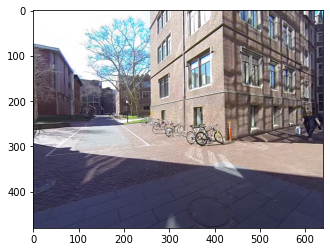

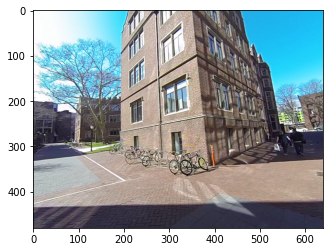

In [2]:
"""  This loads the images.  You must first upload the images to your colab
session.  Each time you start a new session, you will need to upload them again.
"""
im_left = cv2.imread('image0000001.bmp')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('image0000002.bmp')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

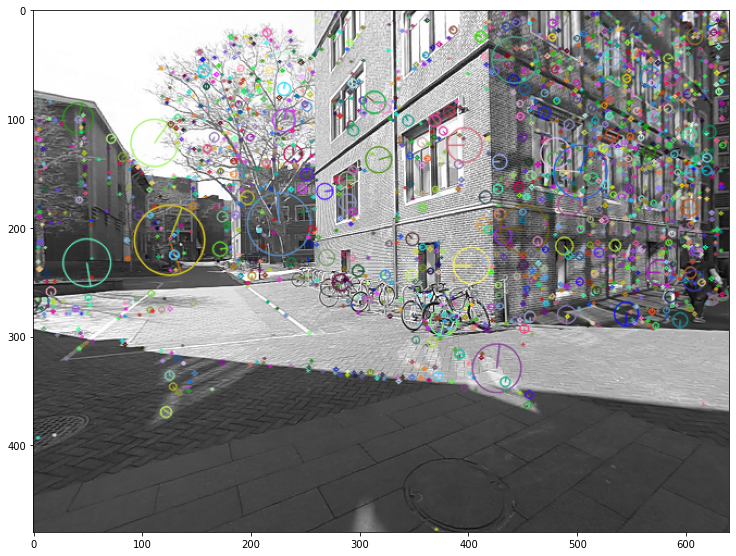

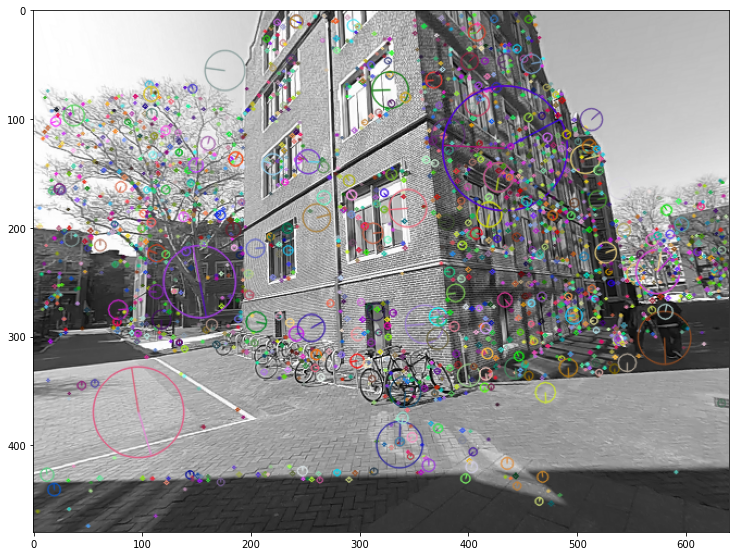

In [3]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 861


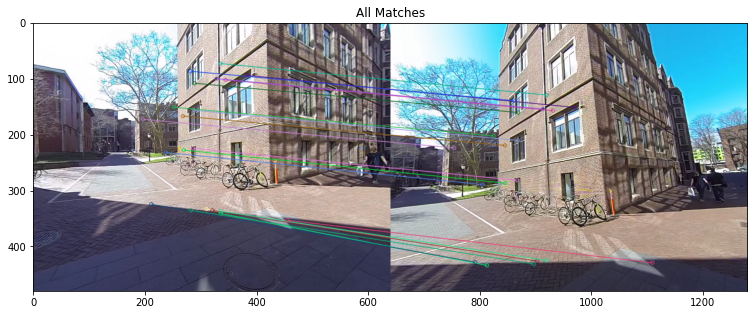

In [4]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])
matches = sorted(matches, key=lambda x:x.distance)

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches[:20], None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)

In [5]:
""" Compute calibrated coordinates
"""
fx = 206.1734
fy = 206.1734
u0 = 173
v0 = 130

K = np.array([[fx, 0, u0],
              [0, fy, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T # 3, N
uncalibrated_2 = np.array(uncalibrated_2).T # 3, N

k_inv = np.linalg.inv(K)

# uncalibrate image points
calibrated_1 = np.matmul(k_inv, uncalibrated_1).T # N, 3
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T # N, 3

**Problem is here!**

We should project E into essential matrix after RANSAC interations, before decompose it into T & R. If we use $E = Udiag(0, 0, 1)V^{T}$ here, the error is quite large.

In [6]:
e3 = np.array([0, 0, 1])

def calculate_error(E, test_X1, test_X2):
  error = np.diagonal(test_X2 @ E @ test_X1.T) ** 2
  error_1 = np.cross(e3, E @ test_X1.T, axisb=0) # M, 3
  error_2 = np.cross(e3, E @ test_X2.T, axisb=0)

  error_1 = np.reciprocal(np.linalg.norm(error_1, ord=2, axis=1))
  error_2 = np.reciprocal(np.linalg.norm(error_2, ord=2, axis=1))

  error_1 = np.multiply(error, error_1)
  error_2 = np.multiply(error, error_2)

  error = error_1 + error_2
  return error


def least_squares_estimation(X1, X2):
  """ YOUR CODE HERE
  """
  N = X1.shape[0]
  A = np.zeros((N, 9))
  for i, (x1, x2) in enumerate(zip(X1, X2)):
    a = np.concatenate([x2[0] * x1, x2[1] * x1, x2[2] * x1])
    A[i] = a
  U, S, V_T = np.linalg.svd(A)
  e = V_T[-1]
  E = e.reshape(3, 3)
  # U, S, V_T = np.linalg.svd(E)
  # E = U @ np.diag((1, 1, 0)) @ V_T
  """ END YOUR CODE
  """
  return E

E_least = least_squares_estimation(calibrated_1[:7], calibrated_2[:7])
print("E least \n", E_least)
print("error \n", calculate_error(E_least, calibrated_1[:7], calibrated_2[:7]))

E least 
 [[-0.0227485   0.27740005 -0.25993735]
 [ 0.3273375   0.13186284 -0.39067317]
 [-0.47242182 -0.19067512  0.56414691]]
error 
 [5.66162104e-33 7.72636765e-33 3.66300129e-32 2.00396513e-32
 3.48437185e-33 1.90997143e-32 6.71519954e-30]


I Use OpenCV as baseline. You can uncomment the OpenCV Code to see the result of OpenCV

calculate error 
 [3.73374988e-07 2.70472795e-07 6.78722576e-07 7.41419967e-13
 4.78665853e-07 2.22307816e-07 1.10321542e-07 2.59162497e-09
 9.23579500e-08 7.73681120e-07 4.41562999e-07 1.56842803e-09
 8.70140595e-07 1.45791088e-08 8.71347225e-07 4.32147672e-07
 8.39237109e-08 6.99552986e-08 3.31636471e-07 1.19392853e-07
 2.90641747e-09 6.16506038e-07 1.32746441e-08 1.10968479e-08
 8.72382924e-08 6.30104075e-07 6.72894167e-07 1.79454696e-07
 3.46703958e-07 4.71876984e-07 2.11046156e-07 5.49422636e-10
 8.63751716e-07 1.23528344e-08 5.74984336e-07 1.52274991e-08
 1.27448207e-07 2.67402924e-07 4.83148525e-07 2.59392182e-07
 1.01550321e-07 2.40996604e-08 8.72382924e-08 7.83755794e-08
 1.19392853e-07 6.78395885e-08 4.55016202e-07 4.97557524e-07
 8.86798168e-07 7.12334194e-07 4.03162577e-11 3.77798758e-07
 8.34600531e-07 9.23579500e-08 9.67375112e-07 2.22307816e-07
 2.79057544e-07 5.69206671e-07 3.80802786e-07 6.00186676e-07
 2.26050183e-32 5.74984336e-07 8.71347225e-07 9.79389763e-08
 2.640

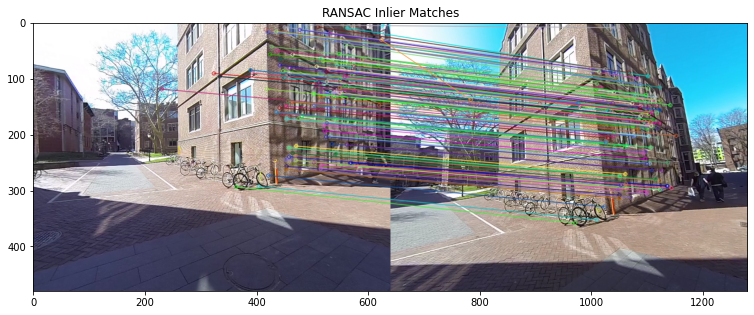

In [15]:
def ransac_estimator(X1, X2):
  num_iterations = 30000
  sample_size = 8

  eps = 1e-6

  best_num_inliers = -1
  best_inliers = None
  best_E = None

  for _ in range(num_iterations):
    permuted_indices = np.random.permutation(np.arange(X1.shape[0]))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]

    """ YOUR CODE HERE
    """
    sample_X1 = X1[sample_indices]
    sample_X2 = X2[sample_indices]
    E = least_squares_estimation(sample_X1, sample_X2)

    test_X1 = X1[test_indices] # M, 3
    test_X2 = X2[test_indices] # M, 3
    error = np.diagonal(test_X2 @ E @ test_X1.T) ** 2
    error_1 = np.cross(e3, E @ test_X1.T, axisb=0) # M, 3
    error_2 = np.cross(e3, E @ test_X2.T, axisb=0)

    error_1 = np.reciprocal(np.linalg.norm(error_1, ord=2, axis=1))
    error_2 = np.reciprocal(np.linalg.norm(error_2, ord=2, axis=1))

    error_1 = np.multiply(error, error_1)
    error_2 = np.multiply(error, error_2)

    error = error_1 + error_2

    loc = np.where(error < eps)
    inliers = np.append(test_indices[loc], sample_indices)
    """ END YOUR CODE
    """
    if inliers.shape[0] > best_num_inliers:
      best_num_inliers = inliers.shape[0]
      best_E = E
      best_inliers = inliers


  return best_E, best_inliers
  
E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
# E_OpenCV, inliers_OpenCV = cv2.findEssentialMat(uncalibrated_1.T[:, :2], uncalibrated_2.T[:, :2], K, method=cv2.RANSAC)
# inliers, _ = np.nonzero(inliers_OpenCV)

# count = 0
# for i in inliers_o:
#   if i in inliers:
#     count += 1
# print("same point:", count)

print("calculate error \n", calculate_error(E_ransac, calibrated_1[inliers], calibrated_2[inliers]))

print("E_ransac", E_ransac)
# print("E_OpenCV", E_OpenCV)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                  keypoints[0],
                  images[1][:, :, ::-1],
                  keypoints[1],
                  inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

In [16]:
# Use RANSAC
inliar_calibrated_1 = calibrated_1[inliers]
inliar_calibrated_2 = calibrated_2[inliers]
E = least_squares_estimation(inliar_calibrated_1, inliar_calibrated_2)
print("calculate error \n", calculate_error(E, inliar_calibrated_1, inliar_calibrated_2))

U, S, V_T = np.linalg.svd(E_ransac)
E_ransac = U @ np.diag((1, 1, 0)) @ V_T

# Use OpenCV
# E_ransac = E_OpenCV

calculate error 
 [3.11674041e-07 2.31840326e-07 1.04391614e-06 1.38221536e-08
 3.37745778e-07 4.05898978e-07 1.91332131e-07 7.45909875e-08
 1.48590560e-08 4.03976038e-07 2.72555875e-07 9.46337539e-10
 9.68403128e-07 1.70640660e-07 3.39493672e-07 1.05618707e-06
 1.97203818e-07 1.74701542e-07 9.26321553e-08 2.61926402e-07
 3.17380200e-08 4.28957896e-07 6.16850882e-08 1.01735517e-07
 7.22908814e-08 7.19002008e-07 4.61875842e-07 9.81037697e-08
 1.57908329e-07 4.61320828e-07 4.46209306e-08 8.14261365e-08
 3.59095218e-07 3.20740741e-08 7.48122452e-07 1.98266360e-07
 1.63921270e-07 1.82871581e-07 2.33111880e-07 4.79414188e-07
 1.77601815e-07 5.17929458e-08 7.22908814e-08 2.74435580e-08
 2.61926402e-07 3.30428509e-08 2.75457855e-07 3.51341808e-07
 8.08797475e-07 6.64799455e-07 4.28659329e-08 6.01115162e-08
 9.18474138e-07 1.48590560e-08 4.79216112e-07 4.05898978e-07
 5.32452539e-07 1.12343755e-06 4.08637515e-07 9.81994206e-08
 2.94550264e-08 7.48122452e-07 3.39493672e-07 5.86960960e-09
 7.356

In [17]:
def plot_lines(lines, h, w):
  """ Utility function to plot lines
  """

  for i in range(lines.shape[1]):
    if abs(lines[0, i] / lines[1, i]) < 1:
      y0 = -lines[2, i] / lines[1, i]
      yw = y0 - w * lines[0, i] / lines[1, i]
      plt.plot([0, w], [y0, yw])
    else:
      x0 = -lines[2, i] / lines[0, i]
      xh = x0 - h * lines[1, i] / lines[0, i]
      plt.plot([x0, xh], [0, h])

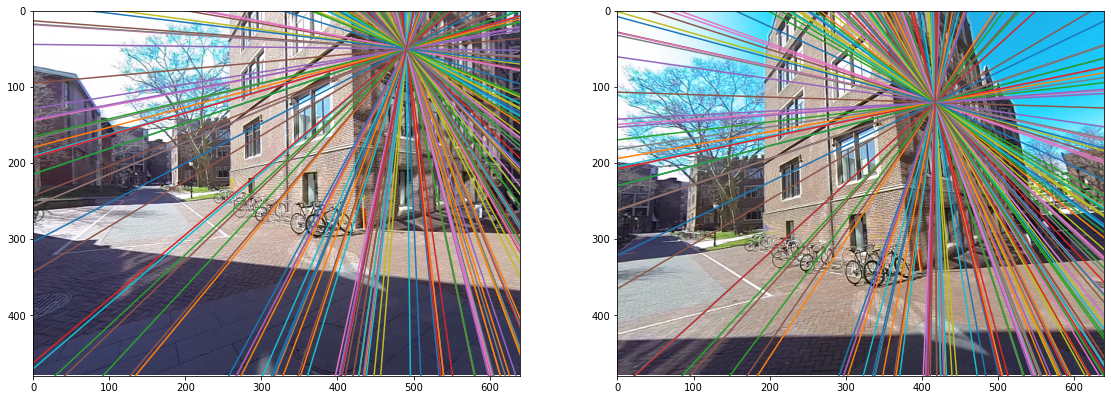

In [18]:
def plot_epipolar_lines(image1, image2, uncalibrated_1, uncalibrated_2, E, K):
  """ Plots the epipolar lines on the images
  """

  """ YOUR CODE HERE
  """
  F = np.linalg.inv(K.T) @ E @ np.linalg.inv(K)
  # plot for image1
  epipolar_lines_in_1 = F.T @ uncalibrated_2 # 3, N

  # plot for image2
  epipolar_lines_in_2 = F @ uncalibrated_1

  """ END YOUR CODE
  """

  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plot_lines(epipolar_lines_in_1, image1.shape[0], image1.shape[1])

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plot_lines(epipolar_lines_in_2, image2.shape[0], image2.shape[1])


uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches] # N, 3
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T # 3, N
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [19]:
def pose_canidates_from_E(E):
  """ YOUR CODE HERE
  """
  U, S, V_T = np.linalg.svd(E)
  R_z = np.array([[0, -1, 0],
           [1, 0, 0],
           [0, 0, 1]])
  R_zm = np.array([[0, 1, 0],
           [-1, 0, 0],
           [0, 0, 1]])
  cadidate1 = {
      'T': U[:, -1],
      'R': U @ R_z.T @ V_T
  }

  cadidate2 = {
      'T': -1 * U[:, -1],
      'R': U @ R_zm.T @ V_T
  }

  cadidate3 = {
      'T': U[:, -1],
      'R': U @ R_zm.T @ V_T
  }

  cadidate4 = {
      'T': -1 * U[:, -1],
      'R': U @ R_z.T @ V_T
  }
  transform_canidates = [cadidate1, cadidate2, cadidate3, cadidate4]

  """ END YOUR CODE
  """
  return transform_canidates



transform_canidates = pose_canidates_from_E(E_ransac)
print("transform_canidates", transform_canidates)

transform_canidates [{'T': array([ 0.76403042, -0.02864334,  0.64454409]), 'R': array([[-0.98924842,  0.08170194,  0.12129448],
       [-0.10163468, -0.980449  , -0.16849374],
       [-0.10515678,  0.1790099 , -0.97821138]])}, {'T': array([-0.76403042,  0.02864334, -0.64454409]), 'R': array([[-0.26480499,  0.2329042 , -0.93575315],
       [ 0.14864889,  0.96865448,  0.19902763],
       [-0.95277585,  0.08639516,  0.29112549]])}, {'T': array([ 0.76403042, -0.02864334,  0.64454409]), 'R': array([[-0.26480499,  0.2329042 , -0.93575315],
       [ 0.14864889,  0.96865448,  0.19902763],
       [-0.95277585,  0.08639516,  0.29112549]])}, {'T': array([-0.76403042,  0.02864334, -0.64454409]), 'R': array([[-0.98924842,  0.08170194,  0.12129448],
       [-0.10163468, -0.980449  , -0.16849374],
       [-0.10515678,  0.1790099 , -0.97821138]])}]


In [20]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')

best 1 (136,)
not best 0
best 135 (136,)
not best 0


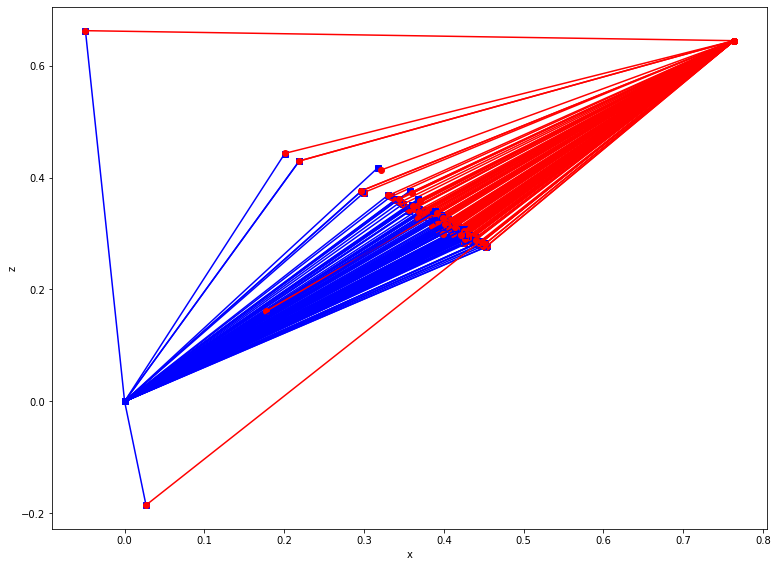

In [21]:
def reconstruct3D(transform_canidates, calibrated_1, calibrated_2):
  """This functions selects (T,R) among the 4 candidates transform_candidates
  such that all triangulated points are in front of both cameras.
  """

  best_num_front = -1
  best_canidate = None
  best_lambdas = None
  for canidate in transform_canidates:
    R = canidate['R']
    T = canidate['T']

    lambdas = np.zeros((2, calibrated_1.shape[0]))
    """ YOUR CODE HERE
    """
    for i in range(calibrated_1.shape[0]):
      P1 = calibrated_1[i]
      P2 = calibrated_2[i]
      A = np.stack([P2, -1*(R @ P1)], axis=1) # 3, 2
      lamb = np.linalg.pinv(A) @ T[:, np.newaxis] # (2, 3)
      lambdas[:, i] = lamb.reshape(-1)
    """ END YOUR CODE
    """
    num_front = np.sum(np.logical_and(lambdas[0]>0, lambdas[1]>0))

    if num_front > best_num_front:
      best_num_front = num_front
      best_canidate = canidate
      best_lambdas = lambdas
      print("best", num_front, best_lambdas[0].shape)
    else:
      print("not best", num_front)


  P1 = best_lambdas[1].reshape(-1, 1) * calibrated_1
  P2 = best_lambdas[0].reshape(-1, 1) * calibrated_2
  T = best_canidate['T']
  R = best_canidate['R']
  return P1, P2, T, R


P1, P2, T, R = reconstruct3D(transform_canidates, calibrated_1[inliers], calibrated_2[inliers])


plot_reconstruction(P1, P2, T, R)

(49, 3)


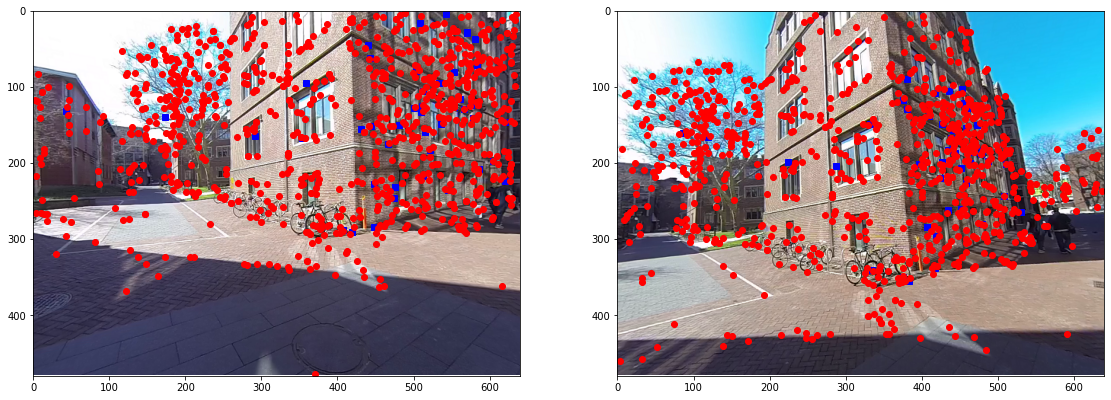

In [14]:
def show_reprojections(image1, image2, uncalibrated_1, uncalibrated_2, P1, P2, K, T, R):

  """ YOUR CODE HERE
  """
  proj2 = R @ P1.T + T[:, np.newaxis] # 3, N
  proj1 = R.T @ (P2.T - T[:, np.newaxis]) # 3, N
  P2proj = (K @ proj1).T
  P1proj = (K @ proj2).T

  print(P2.shape)
  """ END YOUR CODE
  """


  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plt.plot(P2proj[:, 0] / P2proj[:, 2],
           P2proj[:, 1] / P2proj[:, 2], 'bs')
  plt.plot(uncalibrated_1[0, :], uncalibrated_1[1, :], 'ro')

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plt.plot(P1proj[:, 0] / P1proj[:, 2],
           P1proj[:, 1] / P1proj[:, 2], 'bs')
  plt.plot(uncalibrated_2[0, :], uncalibrated_2[1, :], 'ro')

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)